# Response Methods

## TD-DFT v $\Delta$-SCF 

## Transition dipoles

In [3]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import sklearn.metrics

import importlib
import reference_methods
importlib.reload(reference_methods)

<module 'reference_methods' from '/Users/of15641/OneDrive - University of Bristol/Documents/Postgrad_folder/Year_2/chlorophyll_parameterization/tddft_data/reference_methods.py'>

In [4]:
BLYP_df = reference_methods.read_gaussian_method("BLYP")
BLYP_df

,BLYP excitation energy (hr),BLYP excitation energy (eV),BLYP transition dipole,BLYP transition dipole magnitude,BLYP angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.066149,1.8000,"[0.2486, -2.5441, 0.5797]",2.621125,6.535950
step_1_chromophore_2,0.067317,1.8318,"[-1.6087, 1.3157, -1.147]",2.373729,31.386135
step_1_chromophore_3,0.067442,1.8352,"[1.3717, 2.1097, -0.0263]",2.516562,32.920802
step_1_chromophore_4,0.065381,1.7791,"[0.559, -2.5107, 0.3288]",2.593107,22.782308
step_1_chromophore_5,0.066792,1.8175,"[-0.4168, 1.6982, -1.6389]",2.396581,83.333028
...,...,...,...,...,...
step_1851_chromophore_23,0.068185,1.8554,"[0.1158, 1.6771, 1.5547]",2.289796,62.073893
step_1851_chromophore_24,0.067365,1.8331,"[1.6896, -1.9148, -0.0434]",2.554034,50.518264
step_1851_chromophore_25,0.067931,1.8485,"[0.0374, 2.5023, -0.384]",2.531869,28.891234


In [5]:
zindo_df = reference_methods.read_gaussian_method("ZINDO")
zindo_df

,ZINDO excitation energy (hr),ZINDO excitation energy (eV),ZINDO transition dipole,ZINDO transition dipole magnitude,ZINDO angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.043897,1.1945,"[0.7739, -4.4007, 1.1617]",4.616777,9.776992
step_1_chromophore_2,0.047105,1.2818,"[2.8527, -2.3222, 2.015]",4.194131,31.249181
step_1_chromophore_3,0.046433,1.2635,"[2.3927, 3.7036, -0.0545]",4.409607,32.782352
step_1_chromophore_4,0.045040,1.2256,"[1.0718, -4.3251, 0.5297]",4.487296,21.415732
step_1_chromophore_5,0.045859,1.2479,"[-0.9134, 2.7683, -3.0635]",4.228808,79.999027
...,...,...,...,...,...
step_1851_chromophore_23,0.047131,1.2825,"[-0.4788, -2.9891, -3.0966]",4.330462,62.311602
step_1851_chromophore_24,0.046245,1.2584,"[-2.98, 3.1524, 0.074]",4.338606,48.554067
step_1851_chromophore_25,0.048024,1.3068,"[-0.2431, 4.189, -0.7281]",4.258750,33.117726


In [6]:
PBE0_df = reference_methods.read_gaussian_method("PBE0")
PBE0_df

,PBE0 excitation energy (hr),PBE0 excitation energy (eV),PBE0 transition dipole,PBE0 transition dipole magnitude,PBE0 angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.067729,1.8430,"[0.2373, -2.7788, 0.6323]",2.859693,6.473503
step_1_chromophore_2,0.069695,1.8965,"[1.7995, -1.6061, 1.2293]",2.707201,33.397437
step_1_chromophore_3,0.069486,1.8908,"[1.4555, 2.3965, -0.0223]",2.803960,31.174419
step_1_chromophore_4,0.066649,1.8136,"[0.5525, -2.7891, 0.3566]",2.865571,24.114898
step_1_chromophore_5,0.068706,1.8696,"[-0.4684, 1.911, -1.8403]",2.694072,83.350821
...,...,...,...,...,...
step_1851_chromophore_23,0.069813,1.8997,"[-0.1262, -2.1075, -1.9017]",2.841469,61.725364
step_1851_chromophore_24,0.069317,1.8862,"[1.7968, -2.1314, -0.0382]",2.787977,51.815399
step_1851_chromophore_25,0.070022,1.9054,"[0.1378, 2.8176, -0.4237]",2.852609,26.961608


In [26]:
dscf_df = reference_methods.read_excited_scf_method("dscf")
#dscf_df = dscf_df.loc[dscf_df["dscf excitation energy (eV)"] > 1.2]
dscf_df

,dscf excitation energy (hr),dscf excitation energy (eV),dscf transition dipole,dscf transition dipole magnitude,dscf angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.059516,1.619514,"[0.46401, -4.27518, 0.40811]",4.319609,1.758567
step_1_chromophore_2,0.061786,1.681278,"[-3.90424, 0.61879, -1.46521]",4.215784,3.110331
step_1_chromophore_3,0.061954,1.685850,"[0.14018, -4.31685, 0.06546]",4.319621,7.730638
step_1_chromophore_4,0.059589,1.621511,"[2.47946, -3.51776, -0.01642]",4.303792,6.260287
step_1_chromophore_5,0.060622,1.649614,"[-4.12535, -0.71197, -0.72267]",4.248254,2.921076
...,...,...,...,...,...
step_1851_chromophore_23,0.061697,1.678850,"[2.42409, 3.45638, -0.67467]",4.275272,3.310305
step_1851_chromophore_24,0.061240,1.666429,"[-4.21302, -0.09842, 0.1603]",4.217217,0.899453
step_1851_chromophore_25,0.061341,1.669168,"[-2.16654, -3.68105, 0.49031]",4.299352,2.240823


In [8]:
eig_df = reference_methods.read_excited_scf_method("eigdiff")
eig_df

,eigdiff excitation energy (hr),eigdiff excitation energy (eV),eigdiff transition dipole,eigdiff transition dipole magnitude,eigdiff angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.075469,2.053618,"[0.47225, -4.3369, 0.41082]",4.381837,1.797009
step_1_chromophore_2,0.078715,2.141950,"[-3.92634, 0.73373, -1.51811]",4.273074,4.545111
step_1_chromophore_3,0.077284,2.103000,"[-0.16592, 4.34083, -0.2389]",4.350564,9.995884
step_1_chromophore_4,0.072902,1.983756,"[2.47465, -3.56443, -0.19996]",4.343851,8.700933
step_1_chromophore_5,0.077755,2.115830,"[-4.20841, -0.56143, -0.7958]",4.319631,5.169373
...,...,...,...,...,...
step_1851_chromophore_23,0.077910,2.120038,"[-2.45862, -3.51125, 0.68113]",4.340234,3.375106
step_1851_chromophore_24,0.078182,2.127440,"[-4.26399, -0.11454, 0.24429]",4.272518,1.804282
step_1851_chromophore_25,0.078176,2.127275,"[2.19236, 3.72656, -0.51328]",4.353981,2.443995


In [11]:
camb3lyp_df = reference_methods.read_gaussian_method("camb3lyp")
camb3lyp_df

,camb3lyp excitation energy (hr),camb3lyp excitation energy (eV),camb3lyp transition dipole,camb3lyp transition dipole magnitude,camb3lyp angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.061787,1.6813,"[0.2421, -2.9551, 0.6758]",3.041042,6.535779
step_1_chromophore_2,0.064186,1.7466,"[1.8905, -1.711, 1.2962]",2.860358,33.748121
step_1_chromophore_3,0.063620,1.7312,"[1.5416, 2.5659, -0.0187]",2.993447,30.884792
step_1_chromophore_4,0.060879,1.6566,"[0.585, -2.9874, 0.3809]",3.067877,24.238777
step_1_chromophore_5,0.063330,1.7233,"[-0.4768, 2.0383, -1.9437]",2.856567,83.810495
...,...,...,...,...,...
step_1851_chromophore_23,0.064124,1.7449,"[-0.1282, -2.2333, -2.0063]",3.004880,61.696551
step_1851_chromophore_24,0.063499,1.7279,"[1.887, -2.2621, -0.0312]",2.945987,52.116754
step_1851_chromophore_25,0.064800,1.7633,"[0.129, 2.9829, -0.4599]",3.020901,27.305721


In [12]:
wB97XD_df = reference_methods.read_gaussian_method("wB97XD")
wB97XD_df

,wB97XD excitation energy (hr),wB97XD excitation energy (eV),wB97XD transition dipole,wB97XD transition dipole magnitude,wB97XD angle to Na_Nc
chromophore,,,,,
step_1_chromophore_1,0.059651,1.6232,"[0.2395, -3.0008, 0.6854]",3.087383,6.523242
step_1_chromophore_2,0.062257,1.6941,"[1.914, -1.7407, 1.3073]",2.898701,33.865802
step_1_chromophore_3,0.061415,1.6712,"[1.5615, 2.6057, -0.02]",3.037821,30.826030
step_1_chromophore_4,0.058821,1.6006,"[0.5958, -3.037, 0.3856]",3.118819,24.218602
step_1_chromophore_5,0.061382,1.6703,"[-0.4821, 2.0717, -1.9686]",2.898232,83.866992
...,...,...,...,...,...
step_1851_chromophore_23,0.062125,1.6905,"[-0.1296, -2.2653, -2.0303]",3.044749,61.650339
step_1851_chromophore_24,0.061360,1.6697,"[1.9114, -2.2944, -0.0316]",2.986423,52.154235
step_1851_chromophore_25,0.062907,1.7118,"[0.1397, 3.0214, -0.4664]",3.060376,27.139278


In [13]:
result = reference_methods.merge_multiple([PBE0_df, zindo_df, eig_df, BLYP_df, camb3lyp_df, wB97XD_df])
result

,PBE0 excitation energy (hr),PBE0 excitation energy (eV),PBE0 transition dipole,PBE0 transition dipole magnitude,PBE0 angle to Na_Nc,ZINDO excitation energy (hr),ZINDO excitation energy (eV),ZINDO transition dipole,ZINDO transition dipole magnitude,ZINDO angle to Na_Nc,...,wB97XD excitation energy (hr),wB97XD excitation energy (eV),wB97XD transition dipole,wB97XD transition dipole magnitude,wB97XD angle to Na_Nc,camb3lyp excitation energy (hr),camb3lyp excitation energy (eV),camb3lyp transition dipole,camb3lyp transition dipole magnitude,camb3lyp angle to Na_Nc
chromophore,,,,,,,,,,,,,,,,,,,,,
step_1_chromophore_1,0.067729,1.8430,"[0.2373, -2.7788, 0.6323]",2.859693,6.473503,0.043897,1.1945,"[0.7739, -4.4007, 1.1617]",4.616777,9.776992,...,0.059651,1.6232,"[0.2395, -3.0008, 0.6854]",3.087383,6.523242,0.061787,1.6813,"[0.2421, -2.9551, 0.6758]",3.041042,6.535779
step_1_chromophore_2,0.069695,1.8965,"[1.7995, -1.6061, 1.2293]",2.707201,33.397437,0.047105,1.2818,"[2.8527, -2.3222, 2.015]",4.194131,31.249181,...,0.062257,1.6941,"[1.914, -1.7407, 1.3073]",2.898701,33.865802,0.064186,1.7466,"[1.8905, -1.711, 1.2962]",2.860358,33.748121
step_1_chromophore_3,0.069486,1.8908,"[1.4555, 2.3965, -0.0223]",2.803960,31.174419,0.046433,1.2635,"[2.3927, 3.7036, -0.0545]",4.409607,32.782352,...,0.061415,1.6712,"[1.5615, 2.6057, -0.02]",3.037821,30.826030,0.063620,1.7312,"[1.5416, 2.5659, -0.0187]",2.993447,30.884792
step_1_chromophore_4,0.066649,1.8136,"[0.5525, -2.7891, 0.3566]",2.865571,24.114898,0.045040,1.2256,"[1.0718, -4.3251, 0.5297]",4.487296,21.415732,...,0.058821,1.6006,"[0.5958, -3.037, 0.3856]",3.118819,24.218602,0.060879,1.6566,"[0.585, -2.9874, 0.3809]",3.067877,24.238777
step_1_chromophore_5,0.068706,1.8696,"[-0.4684, 1.911, -1.8403]",2.694072,83.350821,0.045859,1.2479,"[-0.9134, 2.7683, -3.0635]",4.228808,79.999027,...,0.061382,1.6703,"[-0.4821, 2.0717, -1.9686]",2.898232,83.866992,0.063330,1.7233,"[-0.4768, 2.0383, -1.9437]",2.856567,83.810495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
step_1851_chromophore_23,0.069813,1.8997,"[-0.1262, -2.1075, -1.9017]",2.841469,61.725364,0.047131,1.2825,"[-0.4788, -2.9891, -3.0966]",4.330462,62.311602,...,0.062125,1.6905,"[-0.1296, -2.2653, -2.0303]",3.044749,61.650339,0.064124,1.7449,"[-0.1282, -2.2333, -2.0063]",3.004880,61.696551
step_1851_chromophore_24,0.069317,1.8862,"[1.7968, -2.1314, -0.0382]",2.787977,51.815399,0.046245,1.2584,"[-2.98, 3.1524, 0.074]",4.338606,48.554067,...,0.061360,1.6697,"[1.9114, -2.2944, -0.0316]",2.986423,52.154235,0.063499,1.7279,"[1.887, -2.2621, -0.0312]",2.945987,52.116754
step_1851_chromophore_25,0.070022,1.9054,"[0.1378, 2.8176, -0.4237]",2.852609,26.961608,0.048024,1.3068,"[-0.2431, 4.189, -0.7281]",4.258750,33.117726,...,0.062907,1.7118,"[0.1397, 3.0214, -0.4664]",3.060376,27.139278,0.064800,1.7633,"[0.129, 2.9829, -0.4599]",3.020901,27.305721


In [27]:
dscf_result = reference_methods.merge_multiple([PBE0_df, dscf_df])

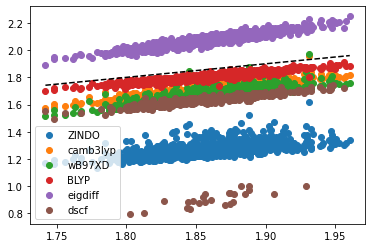

In [28]:
fig, ax = plt.subplots()
ax.scatter(result["PBE0 excitation energy (eV)"], result["ZINDO excitation energy (eV)"], label="ZINDO")
ax.scatter(result["PBE0 excitation energy (eV)"], result["camb3lyp excitation energy (eV)"], label="camb3lyp")
ax.scatter(result["PBE0 excitation energy (eV)"], result["wB97XD excitation energy (eV)"], label="wB97XD")
ax.scatter(result["PBE0 excitation energy (eV)"], result["BLYP excitation energy (eV)"], label="BLYP")
ax.scatter(result["PBE0 excitation energy (eV)"], result["eigdiff excitation energy (eV)"], label="eigdiff")
ax.scatter(dscf_result["PBE0 excitation energy (eV)"], dscf_result["dscf excitation energy (eV)"], label="dscf")

xmin, xmax = min(result["PBE0 excitation energy (eV)"]), max(result["PBE0 excitation energy (eV)"])

ax.plot([xmin, xmax], [xmin, xmax], color='black', linestyle="--")

ax.legend()

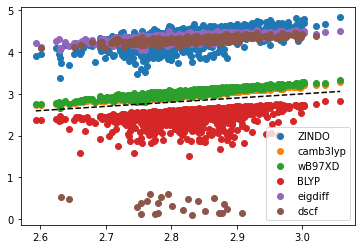

In [29]:
fig, ax = plt.subplots()
ax.scatter(result["PBE0 transition dipole magnitude"], result["ZINDO transition dipole magnitude"], label="ZINDO")
ax.scatter(result["PBE0 transition dipole magnitude"], result["camb3lyp transition dipole magnitude"], label="camb3lyp")
ax.scatter(result["PBE0 transition dipole magnitude"], result["wB97XD transition dipole magnitude"], label="wB97XD")
ax.scatter(result["PBE0 transition dipole magnitude"], result["BLYP transition dipole magnitude"], label="BLYP")
ax.scatter(result["PBE0 transition dipole magnitude"], result["eigdiff transition dipole magnitude"], label="eigdiff")
ax.scatter(dscf_result["PBE0 transition dipole magnitude"], dscf_result["dscf transition dipole magnitude"], label="dscf")


xmin, xmax = min(result["PBE0 transition dipole magnitude"]), max(result["PBE0 transition dipole magnitude"])

ax.plot([xmin, xmax], [xmin, xmax], color='black', linestyle="--")

ax.legend()

In [45]:
def RMSE_e(method1, method2, df):
    return sklearn.metrics.mean_squared_error(df[f"{method1} excitation energy (eV)"], df[f"{method2} excitation energy (eV)"], squared=False)
    
def r2_e(method1, method2, df):
    _, _, r_value, _, _ = linregress(df[f"{method1} excitation energy (eV)"], df[f"{method2} excitation energy (eV)"])
    
    return r_value**2
    
def RMSE_tdm(method1, method2, df):
    return sklearn.metrics.mean_squared_error(df[f"{method1} transition dipole magnitude"], df[f"{method2} transition dipole magnitude"], squared=False)
    
def r2_tdm(method1, method2, df):
    _, _, r_value, _, _ = linregress(df[f"{method1} transition dipole magnitude"], df[f"{method2} transition dipole magnitude"])
    
    return r_value**2

methods = ["PBE0", "camb3lyp", "wB97XD", "BLYP", "eigdiff", "dscf", "ZINDO"]


dscf_df = reference_methods.read_excited_scf_method("dscf")
dscf_df = dscf_df.loc[dscf_df["dscf excitation energy (eV)"] > 1.2]
dscf_result = reference_methods.merge_multiple([PBE0_df, dscf_df])

for m in methods:
    print(m)
    for f in [RMSE_e, r2_e, RMSE_tdm, r2_tdm]:
        if m == "dscf":
            print(f"{f.__name__:<10s} : {f('PBE0', m, dscf_result):>3.3f}")
        else:
            print(f"{f.__name__:<10s} : {f('PBE0', m, result):>3.3f}")
            
            
    print("-"*20)

PBE0
RMSE_e     : 0.000
r2_e       : 1.000
RMSE_tdm   : 0.000
r2_tdm     : 1.000
--------------------
camb3lyp
RMSE_e     : 0.147
r2_e       : 0.795
RMSE_tdm   : 0.172
r2_tdm     : 0.919
--------------------
wB97XD
RMSE_e     : 0.200
r2_e       : 0.650
RMSE_tdm   : 0.214
r2_tdm     : 0.876
--------------------
BLYP
RMSE_e     : 0.053
r2_e       : 0.871
RMSE_tdm   : 0.384
r2_tdm     : 0.129
--------------------
eigdiff
RMSE_e     : 0.218
r2_e       : 0.875
RMSE_tdm   : 1.511
r2_tdm     : 0.500
--------------------
dscf
RMSE_e     : 0.225
r2_e       : 0.847
RMSE_tdm   : 1.455
r2_tdm     : 0.566
--------------------
ZINDO
RMSE_e     : 0.596
r2_e       : 0.339
RMSE_tdm   : 1.526
r2_tdm     : 0.396
--------------------


In [52]:
np.mean(result[f"eigdiff transition dipole magnitude"])

4.341945915242303

In [72]:
pd.set_option('display.max_colwidth', 0)

energies_eV = result.filter(regex="eV")
tdm_mags = result.filter(regex="magnitude")

energy_column_names = energies_eV.columns

energy_cleaned = [x.replace(" excitation energy (eV)", "") for x in energy_column_names]

energies_eV = energies_eV.rename(columns = dict(zip(energy_column_names, energy_cleaned)))

energies_corr = energies_eV.corr().style.set_caption("Excitation Energies correlation")
energies_corr.background_gradient(cmap=plt.get_cmap("RdYlGn"))

tdm_column_names = tdm_mags.columns
tdm_corr = tdm_mags.corr().style.background_gradient(cmap=plt.get_cmap("RdYlGn"))
tdm_cleaned = [x.replace(" transition dipole magnitude", "") for x in tdm_column_names]

tdm_mags = tdm_mags.rename(columns = dict(zip(tdm_column_names, tdm_cleaned)))

tdm_corr = tdm_mags.corr().style.set_caption("Transition Dipole Magnitudes correlation")
tdm_corr.background_gradient(cmap=plt.get_cmap("RdYlGn"))

tdm_corr

import dataframe_image as dfi
dfi.export(energies_corr, "ResponseMethodsEnergiesCorrelations.png")
dfi.export(tdm_corr, "ResponseMethodsTDMSCorrelations.png")


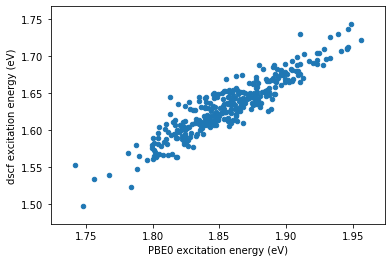

In [282]:
fig, ax = plt.subplots()
temp2.plot.scatter("PBE0 excitation energy (eV)", "dscf excitation energy (eV)", ax = ax)